In [1]:
import numpy as np
import os

from keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

import utils
import Data_loader
from model_simple_multi_unet_model import jacard_coef  

In [30]:
# load INRIA dataset with different locations
# austin, chicago, kitsap, tyrol-w, vienna
locations = ['austin']

base_dir = os.getcwd()
image_dir = os.path.join(base_dir, 'data_INRIA/train/images/')
mask_dir = os.path.join(base_dir, 'data_INRIA/train/gt/')

load_Xtest, load_ytest = Data_loader.load_INRIA(
    image_dir,
    mask_dir,
    locations,
    type = 'test',
    img_size=384)

image size: (980, 384, 384, 3)
mask size: (980, 384, 384, 3)


In [31]:
# load the saved model and perform predictions
base_dir = os.getcwd()
model_name = 'models/bench_ep100_bd15_aus99.h5'
model_path = os.path.join(base_dir, model_name)

model = load_model(model_path, custom_objects={'jacard_coef':jacard_coef})

# make predictions
y_pred = utils.batch_predict(load_Xtest, model, 200, labels=3)

Data size:  980


Predicting batches...: 100%|██████████| 3/3 [00:15<00:00,  5.11s/it]


In [32]:
# convert the predictions to labels, 0 = building, 1 = background, 2 = border
y_pred_argmax = np.argmax(y_pred, axis=3)
prediction = np.where(y_pred_argmax == 0, 0, 1)

# convert true mask to labels, 0 = building, 1 = background, no border needed for evaluation
true = np.where(load_ytest > 10, 0, 1)
true = true[:,:,:,0]

In [33]:
utils.classwiseIoU(prediction, true, model_name)

The classwise IOU: [0.7897 0.9611]
The average IOU: 0.8754308103441951
---------- Results of models/bench_ep100_bd15_aus99.h5 ----------


In [34]:
correct = np.where(prediction == true, 1, 0)
total_correct = np.sum(correct)
total_pixel = correct.shape[0] * correct.shape[1] * correct.shape[2]
print(f'Accuracy = {total_correct/total_pixel}')

Accuracy = 0.9660950537441539


# Start evaluating (Run above to load & get predictions)

In [35]:
def remove_fp(data, window_size, k):
    data_copy = np.copy(data)
    window_idx = np.arange(0+k, data.shape[1]-k, window_size)

    for c,im in enumerate(data_copy):
        for i in window_idx:
            for j in window_idx:
                window = im[j:j+window_size, i:i+window_size]

                # calculate the pixels of border and background
                analyze = np.unique(window, return_counts=True)
                dic = {int(key):analyze[1][count] for count, key in enumerate(analyze[0])}
                d_build = 0
                d_back = 0
                d_bord = 0
                try:
                    d_build = dic[0]
                except:
                    pass
                try:
                    d_back = dic[1]
                except:
                    pass
                try:
                    d_bord = dic[2]
                except:
                    pass

                if d_bord == 0:
                    if d_build * d_back > 0:
                        im[j:j+window_size, i:i+window_size] = 1
    
    return data_copy

## simple 40 window

In [56]:
# select a desired cleaning kernel width
kernel_wid = 32

cleaning = np.copy(y_pred_argmax)

# calculate the shift for the kernel for different iterations
sf = kernel_wid/2
shift = [0, sf, sf/2, 0, sf, sf/2]
kernel_shift = [int(i) for i in shift]
# kernel_shift = np.random.randint(0, kernel_wid/2, 4)

for i in range(len(kernel_shift)):
    cleaning = remove_fp(cleaning, kernel_wid, kernel_shift[i])

# convert the cleaned predictions to labels, 0 = building, 1 = background, 2 = border
prediction_cleaned = np.where(cleaning == 0, 0, 1)

utils.classwiseIoU(prediction_cleaned, true, f'kernel = {kernel_wid}')

The classwise IOU: [0.7862 0.9608]
The average IOU: 0.8734712737401207
---------- Results of kernel = 32 ----------


In [57]:
correct = np.where(prediction_cleaned == true, 1, 0)
total_correct = np.sum(correct)
total_pixel = correct.shape[0] * correct.shape[1] * correct.shape[2]
print(f'Accuracy = {total_correct/total_pixel}')

Accuracy = 0.9657150233954259


0


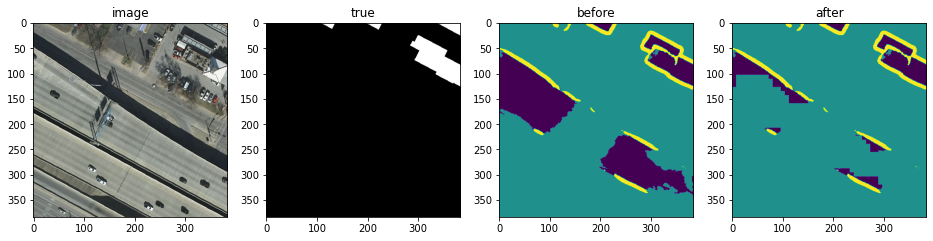

1


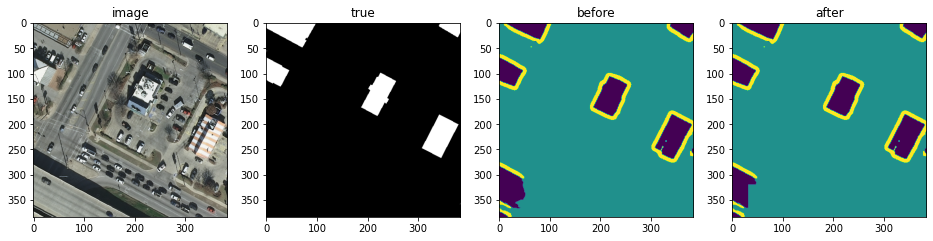

39


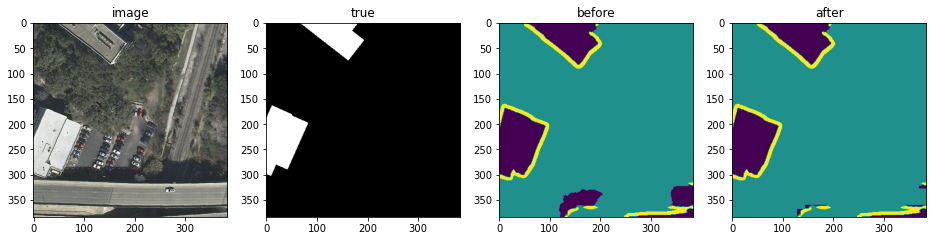

In [60]:
utils.plot4images(
    [load_Xtest, 'image'],
    [load_ytest, 'true'], 
    [y_pred_argmax, 'before'], 
    [cleaning, 'after'], 
    idx_list = [0,1,39]) 